In [1]:
import os
import numpy as np
import tensorflow as tf
from glob import glob
from PIL import Image
# np.random.seed(2024)
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import load_model,Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing import image
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense,Dropout

2024-05-07 07:04:03.146481: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-07 07:04:03.146597: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-07 07:04:03.290755: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
ai_images_path = '/kaggle/input/ai-generated-images-vs-real-images/AiArtData/AiArtData'
real_images_path = '/kaggle/input/ai-generated-images-vs-real-images/RealArt/RealArt'

In [3]:
ai = 0
for filename in os.listdir(ai_images_path):
    if filename.lower().endswith((".jpg", ".jpeg", ".png")):
        ai += 1

real = 0
for filename in os.listdir(real_images_path):
    if filename.lower().endswith((".jpg", ".jpeg", ".png")):
        real += 1
print(ai)
print(real)
print("Total number of datasets:", ai+real)

536
434
Total number of datasets: 970


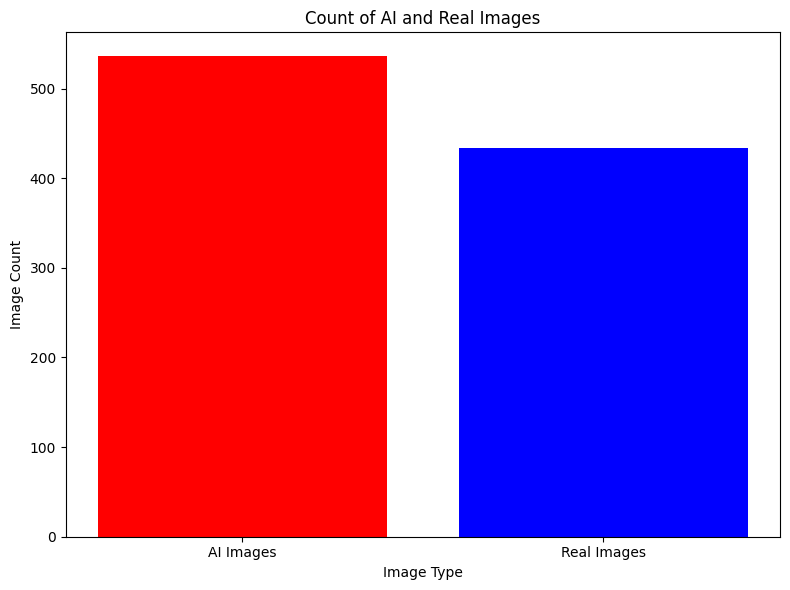

In [4]:
image_types = ["AI Images", "Real Images"]
image_counts = [ai, real]

plt.figure(figsize=(8, 6))
plt.bar(image_types, image_counts, color=['red', 'blue'])
plt.xlabel("Image Type")
plt.ylabel("Image Count")
plt.title("Count of AI and Real Images")
# plt.xticks(rotation=0)


plt.tight_layout()
plt.show()

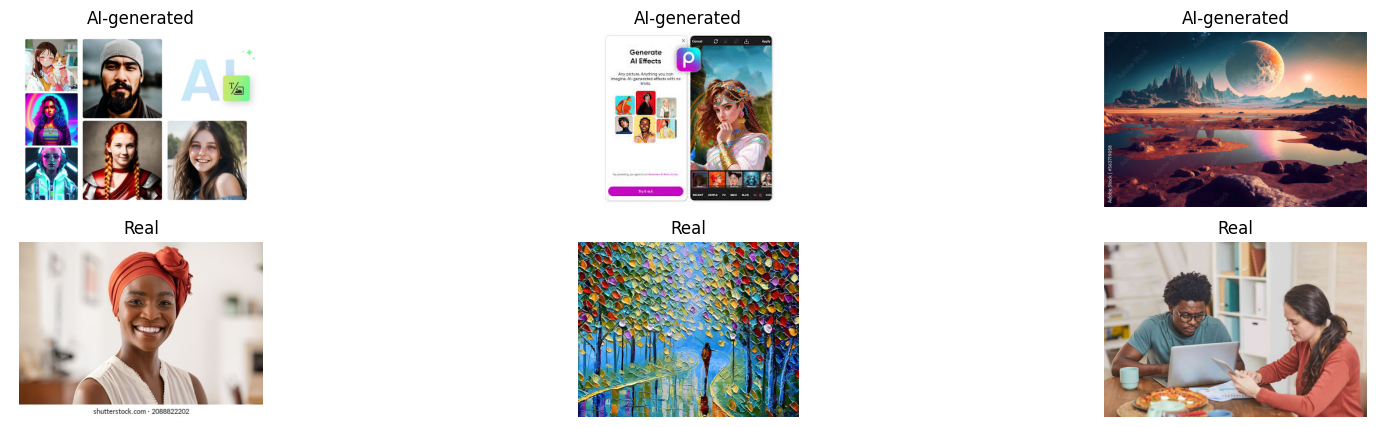

In [5]:
def display_sample_images(ai_images_path, real_images_path, num_images=3):

    fig, axes = plt.subplots(2, num_images, figsize=(20, 5))
    ai_image_paths = [os.path.join(ai_images_path, filename) for filename in os.listdir(ai_images_path)[:num_images]]
    for i, image_path in enumerate(ai_image_paths):
        ax = axes[0, i]
        image = Image.open(image_path)
        ax.imshow(image)
        ax.set_title('AI-generated')
        ax.axis('off')

    real_image_paths = [os.path.join(real_images_path, filename) for filename in os.listdir(real_images_path)[:num_images]]
    for i, image_path in enumerate(real_image_paths):
        ax = axes[1, i]
        image = Image.open(image_path)
        ax.imshow(image)
        ax.set_title('Real')
        ax.axis('off')

    plt.show()

display_sample_images(ai_images_path, real_images_path)

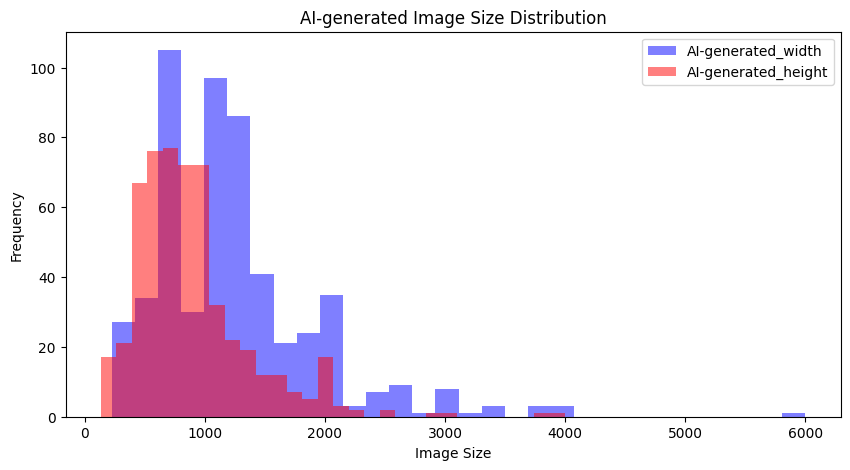

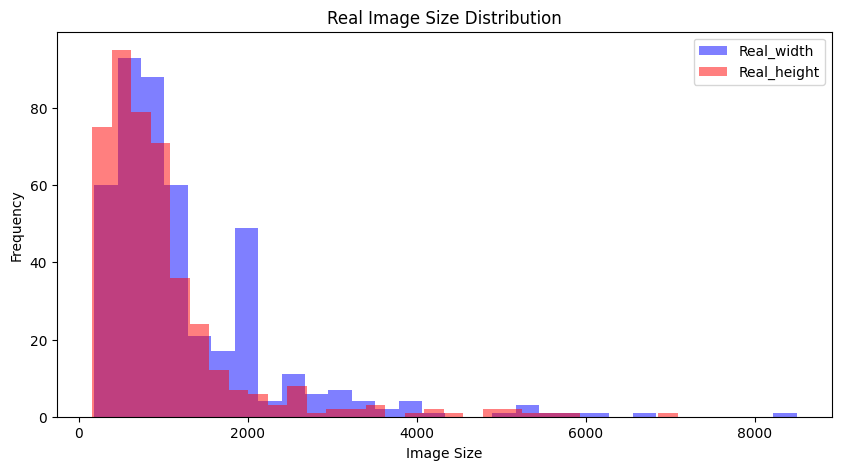

In [6]:
def plot_image_size_distribution(ai_images_path, real_images_path):

    ai_image_paths = [os.path.join(ai_images_path, filename) for filename in os.listdir(ai_images_path)]
    real_image_paths = [os.path.join(real_images_path, filename) for filename in os.listdir(real_images_path)]

    ai_image_sizes = [(Image.open(image_path).size) for image_path in ai_image_paths]
    real_image_sizes = [(Image.open(image_path).size) for image_path in real_image_paths]

    ai_widths = [size[0] for size in ai_image_sizes]
    ai_heights = [size[1] for size in ai_image_sizes]

    real_widths = [size[0] for size in real_image_sizes]
    real_heights = [size[1] for size in real_image_sizes]


    plt.figure(figsize=(10, 5))
    plt.hist(ai_widths, bins=30, alpha=0.5, label='AI-generated_width', color='blue')
    plt.hist(ai_heights, bins=30, alpha=0.5, label='AI-generated_height', color='red')
    plt.title('AI-generated Image Size Distribution')
    plt.xlabel('Image Size')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()


    plt.figure(figsize=(10, 5))
    plt.hist(real_widths, bins=30, alpha=0.5, label='Real_width', color='blue')
    plt.hist(real_heights, bins=30, alpha=0.5, label='Real_height', color='red')
    plt.title('Real Image Size Distribution')
    plt.xlabel('Image Size')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()


plot_image_size_distribution(ai_images_path, real_images_path)

# Balancing data 

In [7]:
import random

def balance_dataset(real_images_path, ai_images_path, new_count=None):

    real_image_count = len(os.listdir(real_images_path))
    ai_image_count = len(os.listdir(ai_images_path))

    if new_count is None:
        target_count = real_image_count
    else:
        target_count = new_count

    images_to_remove = max(ai_image_count - target_count, 0)
    images_to_keep = ai_image_count - images_to_remove

    if images_to_remove > 0:
        print(f"Removing {images_to_remove} images from the AI-generated folder...")

        ai_generated_image_paths = [os.path.join(ai_images_path, f) for f in os.listdir(ai_images_path)]
        random.shuffle(ai_generated_image_paths)


        stratified_indices = random.sample(range(ai_image_count), images_to_keep)
        images_to_keep_paths = [ai_generated_image_paths[i] for i in stratified_indices]

        for image_path in ai_generated_image_paths:
            if image_path not in images_to_keep_paths:
                try:
                    os.remove(image_path)
                except OSError:
                    print(f"Error removing image: {image_path}")

    elif images_to_remove < 0:
        print(f"AI-generated images ({ai_image_count}) already less than or equal to real images ({real_image_count}). No deletion needed.")
    else:
        print("Dataset already balanced (equal number of real and AI-generated images).")

    print("Dataset balancing completed.")



target_count = 434

balance_dataset(real_images_path, ai_images_path, target_count)

Removing 105 images from the AI-generated folder...
Error removing image: /kaggle/input/ai-generated-images-vs-real-images/AiArtData/AiArtData/ah3-932b64a175ba.jpeg
Error removing image: /kaggle/input/ai-generated-images-vs-real-images/AiArtData/AiArtData/96715731.jpg
Error removing image: /kaggle/input/ai-generated-images-vs-real-images/AiArtData/AiArtData/cute-furry-animal-ai-generated_970779-15.jpg
Error removing image: /kaggle/input/ai-generated-images-vs-real-images/AiArtData/AiArtData/ting-art-on-a-canvas-with-many-colors-in-art-nouveau-style-1-e1670998298608.jpeg
Error removing image: /kaggle/input/ai-generated-images-vs-real-images/AiArtData/AiArtData/Fotor-AI-portrait-generator-interface.jpg
Error removing image: /kaggle/input/ai-generated-images-vs-real-images/AiArtData/AiArtData/MIT-3Q-GenerativeAI-01-press.jpg
Error removing image: /kaggle/input/ai-generated-images-vs-real-images/AiArtData/AiArtData/young-woman-eye-reflects-colorful-summer-nature-generated-by-ai_188544-1840

# Model Building

In [8]:
IMG_WIDTH, IMG_HEIGHT = 224, 224

real_image_files = [os.path.join(real_images_path, f) for f in os.listdir(real_images_path)]
ai_image_files = [os.path.join(ai_images_path, f) for f in os.listdir(ai_images_path)]

image_files = real_image_files + ai_image_files
labels = [0] * len(real_image_files) + [1] * len(ai_image_files)

In [9]:
len(labels)

975

In [10]:
import pandas as pd
df = pd.DataFrame({'image_files': image_files, 'labels': labels})

X_train, X_test, y_train, y_test = train_test_split(df['image_files'], df['labels'], test_size=0.2, random_state=42)

In [11]:
train_datagen = ImageDataGenerator(rotation_range=40, width_shift_range=0.2, height_shift_range=0.2, shear_range=0.2, zoom_range=0.2,horizontal_flip=True,fill_mode='nearest',rescale=1./255  )
test_datagen = ImageDataGenerator(rescale=1./255)

In [12]:
df['labels'] = df['labels'].astype(str)
train_generator = train_datagen.flow_from_dataframe(dataframe=df, x_col='image_files', y_col='labels', target_size=(IMG_WIDTH, IMG_HEIGHT),batch_size=32, class_mode='binary')
validation_generator = test_datagen.flow_from_dataframe(dataframe=df, x_col='image_files', y_col='labels', target_size=(IMG_WIDTH, IMG_HEIGHT),batch_size=32,class_mode='binary')

Found 970 validated image filenames belonging to 2 classes.
Found 970 validated image filenames belonging to 2 classes.


/opt/conda/lib/python3.10/site-packages/keras/src/legacy/preprocessing/image.py:920: UserWarning: Found 5 invalid image filename(s) in x_col="image_files". These filename(s) will be ignored.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/keras/src/legacy/preprocessing/image.py:920: UserWarning: Found 5 invalid image filename(s) in x_col="image_files". These filename(s) will be ignored.
  warnings.warn(


# Using CNN

In [13]:
model1 = Sequential()
model1.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model1.add(MaxPooling2D((2, 2)))
model1.add(Conv2D(64, (3, 3), activation='relu'))
model1.add(MaxPooling2D((2, 2)))
model1.add(Conv2D(128, (3, 3), activation='relu'))
model1.add(MaxPooling2D((2, 2)))
model1.add(Flatten())
model1.add(Dense(128, activation='relu'))
model1.add(Dropout(0.5))
model1.add(Dense(64, activation='relu'))
model1.add(Dense(1, activation='sigmoid'))

model1.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


In [14]:
history1= model1.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=10,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size)

Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


 5/30 ━━━━━━━━━━━━━━━━━━━━ 1:06 3s/step - accuracy: 0.4853 - loss: 1.4834

/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


30/30 ━━━━━━━━━━━━━━━━━━━━ 111s 3s/step - accuracy: 0.4877 - loss: 1.0206 - val_accuracy: 0.5531 - val_loss: 0.6833
Epoch 2/10
 1/30 ━━━━━━━━━━━━━━━━━━━━ 45s 2s/step - accuracy: 0.5625 - loss: 0.6819

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


30/30 ━━━━━━━━━━━━━━━━━━━━ 7s 188ms/step - accuracy: 0.5625 - loss: 0.6819 - val_accuracy: 0.5000 - val_loss: 0.6981
Epoch 3/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 102s 3s/step - accuracy: 0.5072 - loss: 0.6905 - val_accuracy: 0.5521 - val_loss: 0.6635
Epoch 4/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5312 - loss: 0.6679 - val_accuracy: 0.6000 - val_loss: 0.6366
Epoch 5/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 141s 3s/step - accuracy: 0.5513 - loss: 0.6662 - val_accuracy: 0.6448 - val_loss: 0.6841
Epoch 6/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 7s 178ms/step - accuracy: 0.5625 - loss: 0.7009 - val_accuracy: 0.5000 - val_loss: 0.6953
Epoch 7/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 135s 3s/step - accuracy: 0.6330 - loss: 0.6753 - val_accuracy: 0.5802 - val_loss: 0.6497
Epoch 8/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 7s 190ms/step - accuracy: 0.6250 - loss: 0.6046 - val_accuracy: 0.6000 - val_loss: 0.7195
Epoch 9/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 134s 3s/step - accuracy: 0.5996 - loss: 0.6798 - val_accuracy: 0.6281 - val_loss: 

# Mobile Net V2

In [15]:
mobilenet_model = MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet', pooling='avg')

# Freeze the pre-trained layers
mobilenet_model.trainable = False

model5 = Sequential([
    mobilenet_model,
    Dense(128, activation='relu'),  # Hidden layer
    Dropout(0.5),  # Dropout for regularization
    Dense(1, activation='sigmoid')
])

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [16]:
model5.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

In [17]:
history5= model5.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=10,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size
)

Epoch 1/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 91s 3s/step - accuracy: 0.6125 - loss: 0.7755 - val_accuracy: 0.7448 - val_loss: 0.5150
Epoch 2/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.7500 - loss: 0.6555 - val_accuracy: 0.8000 - val_loss: 0.4437
Epoch 3/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - accuracy: 0.7246 - loss: 0.5490 - val_accuracy: 0.7750 - val_loss: 0.4677
Epoch 4/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6562 - loss: 0.5314 - val_accuracy: 0.6000 - val_loss: 0.5488
Epoch 5/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 83s 2s/step - accuracy: 0.7664 - loss: 0.4625 - val_accuracy: 0.7844 - val_loss: 0.4488
Epoch 6/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 7s 211ms/step - accuracy: 0.8438 - loss: 0.3586 - val_accuracy: 0.8000 - val_loss: 0.7046
Epoch 7/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 83s 3s/step - accuracy: 0.8124 - loss: 0.4341 - val_accuracy: 0.8271 - val_loss: 0.4086
Epoch 8/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7812 - loss: 0.4889 - val_accuracy: 0.9000 - val_lo

# Plotting graphs 

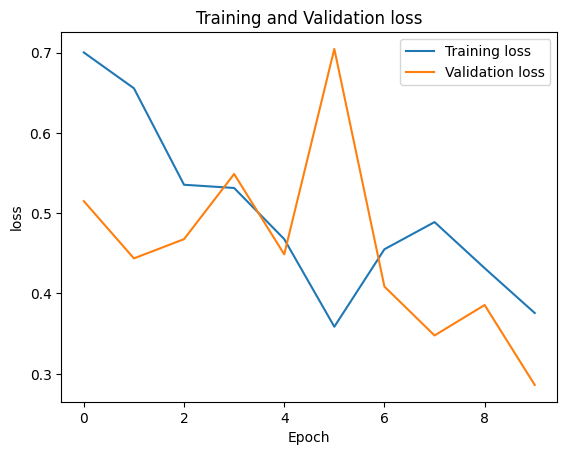

In [18]:
plt.plot(history5.history['loss'], label='Training loss')
plt.plot(history5.history['val_loss'], label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

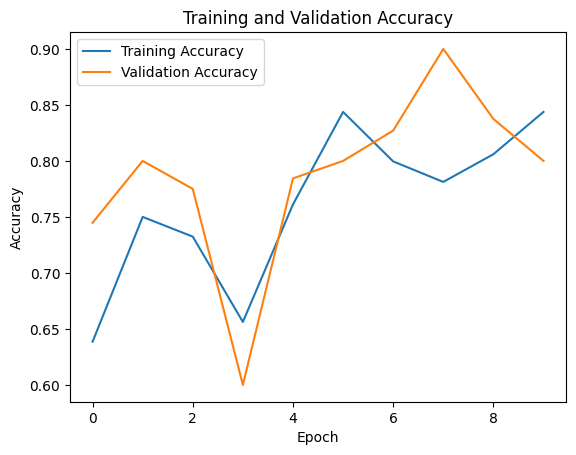

In [19]:
plt.plot(history5.history['accuracy'], label='Training Accuracy')
plt.plot(history5.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Predicting data

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
<PIL.Image.Image image mode=RGB size=224x224 at 0x78DB2F975FF0>
Prediction: Real image


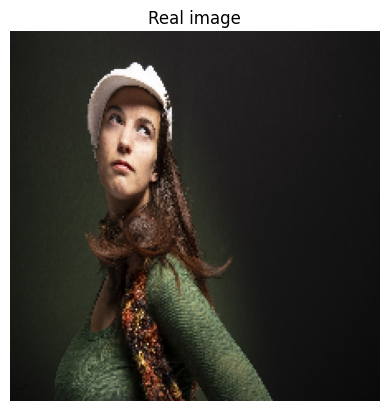

In [20]:
img_path = "/kaggle/input/ai-generated-images-vs-real-images/RealArt/RealArt/10-tips-for-stunning-portrait-photography-7.jpg"
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = img_array / 255.0
img_array = np.expand_dims(img_array, axis=0)

prediction = model5.predict(img_array)
print(img)
if prediction[0] > 0.5:
     prediction_text = "AI-generated image"
else:
    prediction_text = "Real image"
print("Prediction:", prediction_text)

plt.imshow(img_array[0])
plt.title(prediction_text)
plt.axis('off')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Prediction: Real image


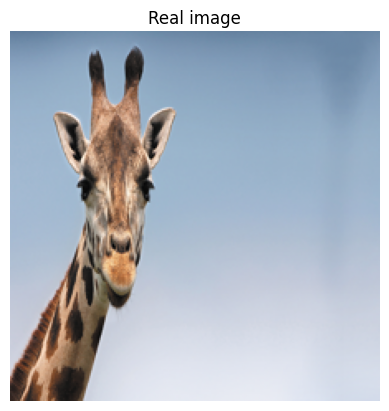

In [21]:
try:
    input_image = Image.open('/kaggle/input/ai-generated-images-vs-real-images/RealArt/RealArt/2020-03-feature-giraffe_tcm7-269465.png')
    input_image = input_image.resize((IMG_WIDTH, IMG_HEIGHT))
    input_image = np.array(input_image) / 255.0
    input_image = np.expand_dims(input_image, axis=0)
except Exception as e:
    print("Error loading or preprocessing the input image:", e)

try:
    predictions = model5.predict(input_image)
    if predictions[0][0] >= 0.5:
        prediction_text = "AI-generated image"
    else:
        prediction_text = "Real image"
    print("Prediction:", prediction_text)

    plt.imshow(input_image[0])
    plt.title(prediction_text)
    plt.axis('off')
    plt.show()

except Exception as e:
    print("Error making predictions:", e)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Prediction: AI-generated image


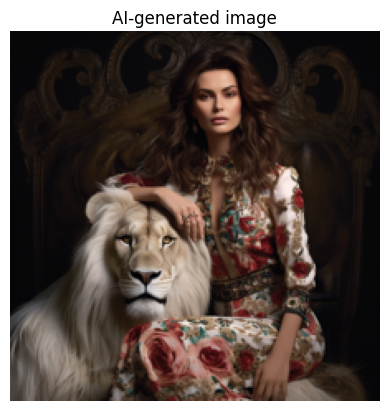

In [22]:
try:
    input_image = Image.open('/kaggle/input/ai-generated-images-vs-real-images/AiArtData/AiArtData/1Mcde2p8rG0uUjwwQ-tGWLg.png')
    input_image = input_image.resize((IMG_WIDTH, IMG_HEIGHT))
    input_image = np.array(input_image) / 255.0
    input_image = np.expand_dims(input_image, axis=0)
except Exception as e:
    print("Error loading or preprocessing the input image:", e)

try:
    predictions = model5.predict(input_image)
    if predictions[0][0] >= 0.5:
        prediction_text = "AI-generated image"
    else:
        prediction_text = "Real image"
    print("Prediction:", prediction_text)

    plt.imshow(input_image[0])
    plt.title(prediction_text)
    plt.axis('off')
    plt.show()

except Exception as e:
    print("Error making predictions:", e)